In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install mne
!pip install autoreject

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import autoreject
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
import seaborn as sns

In [36]:
data_folder= '/content/drive/MyDrive/'

In [48]:
subjectIds = ['sub-{:03d}'.format(i) for i in range(1,150)]


Steps for preprocessing
#Importing the raw data.
#Downsample the data.
#High pass filter.
#Re-reference data.
#Inspect and reject noisy epochs.
#Run independent component analysis and reject noisy components.

Reading /content/drive/MyDrive/datasets/sub-004/eeg/sub-004_task-Rest_eeg.fdt
Reading 0 ... 131979  =      0.000 ...   263.958 secs...


<ipython-input-49-99deacdcef21>:3: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(subject_file, preload=True, verbose=True)
<ipython-input-49-99deacdcef21>:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(subject_file, preload=True, verbose=True)


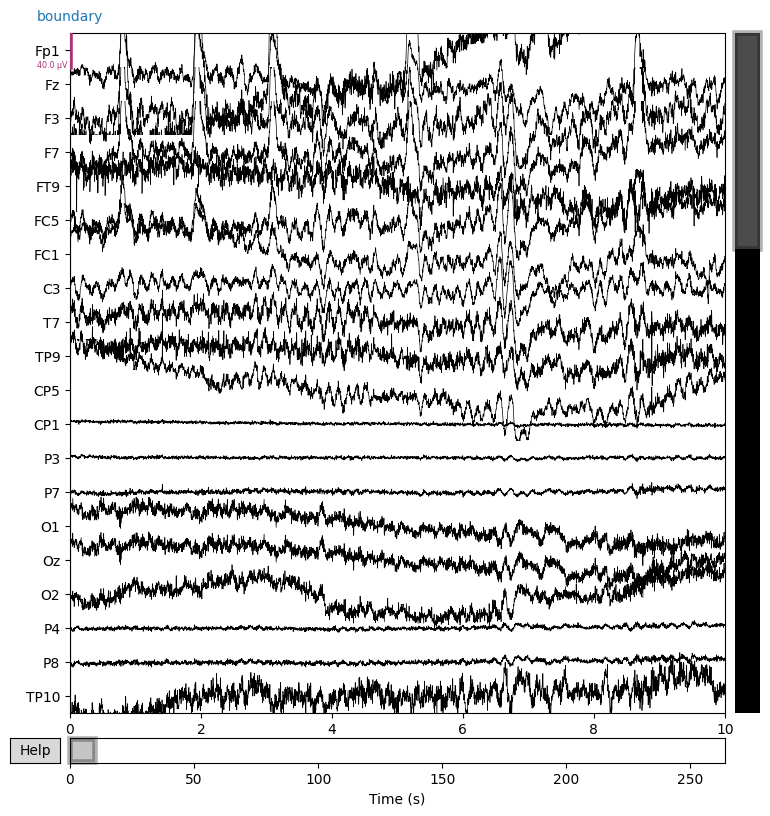

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1651 samples (6.604 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Not setting metadata
19 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.3s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 59 PCA components


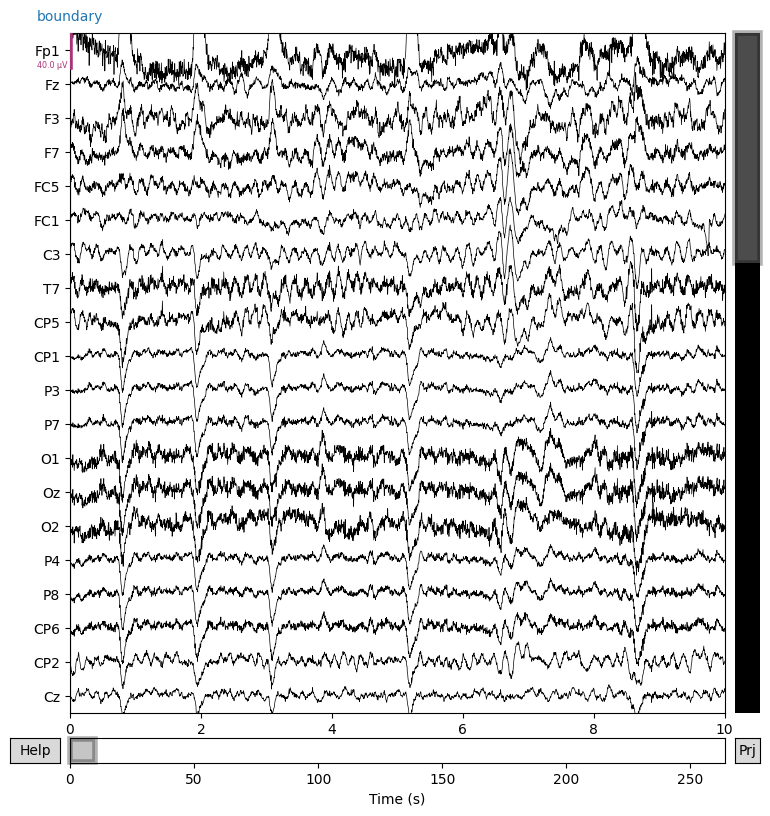

In [49]:
for subId in subjectIds:
  subject_file = os.path.join(data_folder, f'datasets/{subId}/eeg/{subId}_task-Rest_eeg.set')
  raw = mne.io.read_raw_eeglab(subject_file, preload=True, verbose=True)
  #Plot Graph
  raw.plot()
  channel_drops=['FT9','FT10','TP9','TP10']
  channels_to_drop = [channel for channel in channel_drops if channel in raw.info['ch_names']]
  if channels_to_drop:
    raw.drop_channels(channels_to_drop)
  raw.resample(250)#resample the data
  raw.filter(0.5,None) #filtering
  #Referencing
  raw.set_eeg_reference(ref_channels='average', projection=True)
  events = mne.make_fixed_length_events(raw, start=0, stop=10, duration=1., overlap=0.5)
  epochs = mne.Epochs(raw, events, preload=True).pick_types(eeg=True) #Epoch data
  autor= autoreject.AutoReject(n_interpolate=[1,2,3,4],random_state=11,n_jobs=1,verbose=True)
  ica =mne.preprocessing.ICA(n_components=15,random_state=0)
  ica.fit(raw)
  raw=ica.apply(raw) #apply ICA
  #raw.save(f'/content/drive/MyDrive/preprocessed/{subId}-preprocessed_data_eeg.fif', overwrite=True) #Save processed data
  raw.plot()

#Function for scale values

In [ ]:
def scaled_values(mean_value):
  values_array = np.array(mean_value).reshape(-1,1)
  # Calculate the minimum and maximum values in the original array
  min_value = np.min(values_array)
  max_value = np.max(values_array)
  scaler = MinMaxScaler(feature_range=(0, 1))

  # Perform Min-Max scaling
  scaled_mean_values = scaler.fit_transform(values_array)
  return scaled_mean_values;

#Feature Extraction

In [ ]:
mean_value=[]
variance_value=[]
featuredf=[]
response_time=[]
fmin = 1  # Minimum frequency
fmax = 40  # Maximum frequency
for subId in subjectIds:
  sub_file=os.path.join(data_folder,f'preprocessed/{subId}-preprocessed_data_eeg.fif')
  raw = mne.io.read_raw_fif(sub_file, preload=True, verbose=True)
  events = mne.make_fixed_length_events(raw, start=0, stop=10, duration=1., overlap=0.5)
  epochs = mne.Epochs(raw, events,baseline=None, preload=True).pick_types(eeg=True) #Epoch data
  freq_bands = {'delta': (1, 4),
              'theta': (4, 8),
              'alpha': (8, 13),
              'beta': (13, 30),
              'gamma': (30, 100)}

  for ch_idx in range(len(raw.info['ch_names'])):
     eegdata = epochs.get_data()[:, ch_idx, :]
     mean_v = np.mean(eegdata)
     mean_value.append(mean_v)
     variance_v = np.var(eegdata)
     variance_value.append(variance_v)
  scaled_mean_values=scaled_values(mean_value)
  scaled_variance_values=scaled_values(variance_value)


  # Define parameters
  sampling_rate = 250  # EEG sampling rate in Hz
  time_window = 0.5    # Time window after stimulus onset to analyze (in seconds)
  threshold = 10       # Minimum amplitude difference for peak detection

  # Define the time range for event detection (in seconds)
  event_detection_window = 0.6
#'response_time':np.mean(response_time),
  # List to store event markers
  event_markers = []
  # Generate EEG timestamps based on the sampling rate
  eeg_duration = 20  # Duration of EEG recording in seconds
  num_samples = int(sampling_rate * eeg_duration)
  eeg_timestamps = np.linspace(0, eeg_duration, num_samples, endpoint=False)
  eeg_timestamps=np.array(eeg_timestamps)
  for timestamp in eeg_timestamps:
      readable_timestamp = round(timestamp, 6)
  # Print the generated EEG timestamps
  print("EEG timestamps:", readable_timestamp)
  # Loop through EEG timestamps to find events within the specified window
  for timestamp in eeg_timestamps:
          event_markers.append(timestamp)



  # Loop through each stimulus onset event
  for event_time in event_markers:
      start_sample = int(event_time * sampling_rate)
      end_sample = int((event_time + time_window) * sampling_rate)
      # Extract EEG data in the time window
      eeg_window = raw[:, start_sample:end_sample]

      # Calculate mean amplitude across EEG channels (you might need to adapt this to your data structure)
      mean_amplitude = np.mean(eeg_window, axis=0)
      mean_amplitude = mean_amplitude.flatten()
      # Find peaks in the mean amplitude signal
      peaks, _ = find_peaks(mean_amplitude, height=threshold)
      peaks
      if peaks.size > 0:
          # Assuming peaks[0] is the index of the first peak, you can convert it to time
          peak_time = peaks[0] / sampling_rate
          # Calculate response time as the time from stimulus onset to peak
          response_time.append(event_time-peak_time)

          #print(f"Response time for event at {event_time:.2f} seconds: {response_time:.2f} seconds")
  response_time
  raw.filter(0.1, 20)
  tmin_p3_simon = 0.4
  tmax_p3_simon = 0.5
  tmin_p3_oddball = 0.25
  tmax_p3_oddball = 0.35
  tmin_n1_oddball = 0.05
  tmax_n1_oddball = 0.15
  tmin_first_negative = 0.15
  tmax_first_negative = 0.35
  # Create epochs for each ERP component
  event_id = {'boundary': 1}
  epochs_p3_simon = mne.Epochs(raw, events, event_id=event_id, tmin=tmin_p3_simon, tmax=tmax_p3_simon, baseline=None, preload=True)
  epochs_p3_oddball = mne.Epochs(raw, events, event_id=event_id, tmin=tmin_p3_oddball, tmax=tmax_p3_oddball, baseline=None, preload=True)
  epochs_n1_oddball = mne.Epochs(raw, events, event_id=event_id, tmin=tmin_n1_oddball, tmax=tmax_n1_oddball, baseline=None, preload=True)
  epochs_first_negative = mne.Epochs(raw, events, event_id=event_id, tmin=tmin_first_negative, tmax=tmax_first_negative, baseline=None, preload=True)

  # Select the electrode Cz
  electrode = 'Cz'

  # Calculate mean amplitude for each component
  epochs_p3_simon.load_data()
  epochs_p3_oddball.load_data()
  epochs_n1_oddball.load_data()
  epochs_first_negative.load_data()

  # Now, you can perform channel picking and data manipulation as before
  mean_amplitude_p3_simon = epochs_p3_simon.copy().pick_channels([electrode]).crop(tmin=tmin_p3_simon, tmax=tmax_p3_simon).get_data().mean(axis=2)
  mean_amplitude_p3_oddball = epochs_p3_oddball.copy().pick_channels([electrode]).crop(tmin=tmin_p3_oddball, tmax=tmax_p3_oddball).get_data().mean(axis=2)
  mean_amplitude_n1_oddball = epochs_n1_oddball.copy().pick_channels([electrode]).crop(tmin=tmin_n1_oddball, tmax=tmax_n1_oddball).get_data().mean(axis=2)

  scale_amplitude_p3_simon=scaled_values(mean_amplitude_p3_simon)
  scale_amplitude_p3_oddball=scaled_values(mean_amplitude_p3_oddball)
  scale_amplitude_n1_oddball=scaled_values(mean_amplitude_n1_oddball)


  # Define frequency bands of interest
  freq_delta = (1, 4)  # Delta band (1-4 Hz)
  freq_theta = (4, 7)  # Theta band (4-7 Hz)


  # Simon task
  tf_roi_simon_delta = (0.4, 0.7)
  tf_roi_simon_theta = (0.1, 0.4)

  # Compute time-frequency representations using Morlet wavelets
  freqs = np.logspace(np.log10(1), np.log10(50), 50)  # Frequency range from 1 Hz to 50 Hz
  n_cycles = freqs / 2.0  # Set the number of cycles based on frequency
  time_bandwidth = 2.0    # Adjust as needed

  tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, time_bandwidth=time_bandwidth, return_itc=False)
  # Extract data for your tf-ROIs
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window

  scale_power_simon_delta=scaled_values(power_simon_delta)
  scale_power_simon_theta=scaled_values(power_simon_theta)

  feature_values = {
        "SubjectID":subId,
        'Mean': np.mean(scaled_mean_values),
        'Variance':np.mean(scaled_variance_values),
        'p3_simon_amplitude':np.mean(scale_amplitude_p3_simon),
        'p3_oddball_amplitude':np.mean(scale_amplitude_p3_oddball),
        'n1_oddball_amplitude':np.mean(scale_amplitude_n1_oddball),
        'Power_delta':np.mean(scale_power_simon_delta),
        'Power_theta':np.mean(scale_power_simon_theta)
    }
  featuredf.append(feature_values)

featuredf
features_df = pd.DataFrame(featuredf)
csv_file_path = '/content/drive/MyDrive/featuresdata.csv'
# Save the DataFrame as a CSV file at the specified path
features_df.to_csv(csv_file_path, index=False)
print(f"CSV file '{csv_file_path}' has been created.")

Opening raw data file /content/drive/MyDrive/preprocessed/sub-001-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 70414 =      0.000 ...   281.656 secs
Ready.
Reading 0 ... 70414  =      0.000 ...   281.656 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-002-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Range : 0 ... 81509 =      0.000 ...   326.036 secs
Ready.
Reading 0 ... 81509  =      0.000 ...   326.036 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-003-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 63089 =      0.000 ...   252.356 secs
Ready.
Reading 0 ... 63089  =      0.000 ...   252.356 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-004-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 65989 =      0.000 ...   263.956 secs
Ready.
Reading 0 ... 65989  =      0.000 ...   263.956 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-005-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 62384 =      0.000 ...   249.536 secs
Ready.
Reading 0 ... 62384  =      0.000 ...   249.536 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-006-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 65514 =      0.000 ...   262.056 secs
Ready.
Reading 0 ... 65514  =      0.000 ...   262.056 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-007-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 59954 =      0.000 ...   239.816 secs
Ready.
Reading 0 ... 59954  =      0.000 ...   239.816 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-008-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 58619 =      0.000 ...   234.476 secs
Ready.
Reading 0 ... 58619  =      0.000 ...   234.476 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-009-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 62039 =      0.000 ...   248.156 secs
Ready.
Reading 0 ... 62039  =      0.000 ...   248.156 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-010-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 85674 =      0.000 ...   342.696 secs
Ready.
Reading 0 ... 85674  =      0.000 ...   342.696 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-011-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 39029 =      0.000 ...   156.116 secs
Ready.
Reading 0 ... 39029  =      0.000 ...   156.116 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-012-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30139 =      0.000 ...   120.556 secs
Ready.
Reading 0 ... 30139  =      0.000 ...   120.556 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-013-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30764 =      0.000 ...   123.056 secs
Ready.
Reading 0 ... 30764  =      0.000 ...   123.056 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-014-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31399 =      0.000 ...   125.596 secs
Ready.
Reading 0 ... 31399  =      0.000 ...   125.596 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-015-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30204 =      0.000 ...   120.816 secs
Ready.
Reading 0 ... 30204  =      0.000 ...   120.816 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-016-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30414 =      0.000 ...   121.656 secs
Ready.
Reading 0 ... 30414  =      0.000 ...   121.656 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-017-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 46304 =      0.000 ...   185.216 secs
Ready.
Reading 0 ... 46304  =      0.000 ...   185.216 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-018-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37889 =      0.000 ...   151.556 secs
Ready.
Reading 0 ... 37889  =      0.000 ...   151.556 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-019-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 46519 =      0.000 ...   186.076 secs
Ready.
Reading 0 ... 46519  =      0.000 ...   186.076 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-020-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 45294 =      0.000 ...   181.176 secs
Ready.
Reading 0 ... 45294  =      0.000 ...   181.176 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-021-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 39834 =      0.000 ...   159.336 secs
Ready.
Reading 0 ... 39834  =      0.000 ...   159.336 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-022-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 38434 =      0.000 ...   153.736 secs
Ready.
Reading 0 ... 38434  =      0.000 ...   153.736 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-023-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 42274 =      0.000 ...   169.096 secs
Ready.
Reading 0 ... 42274  =      0.000 ...   169.096 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-024-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37824 =      0.000 ...   151.296 secs
Ready.
Reading 0 ... 37824  =      0.000 ...   151.296 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-025-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 40974 =      0.000 ...   163.896 secs
Ready.
Reading 0 ... 40974  =      0.000 ...   163.896 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-026-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 35704 =      0.000 ...   142.816 secs
Ready.
Reading 0 ... 35704  =      0.000 ...   142.816 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-027-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30299 =      0.000 ...   121.196 secs
Ready.
Reading 0 ... 30299  =      0.000 ...   121.196 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-028-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 38649 =      0.000 ...   154.596 secs
Ready.
Reading 0 ... 38649  =      0.000 ...   154.596 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-029-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 50834 =      0.000 ...   203.336 secs
Ready.
Reading 0 ... 50834  =      0.000 ...   203.336 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-030-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 44034 =      0.000 ...   176.136 secs
Ready.
Reading 0 ... 44034  =      0.000 ...   176.136 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-031-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 45334 =      0.000 ...   181.336 secs
Ready.
Reading 0 ... 45334  =      0.000 ...   181.336 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-032-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37899 =      0.000 ...   151.596 secs
Ready.
Reading 0 ... 37899  =      0.000 ...   151.596 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-033-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32839 =      0.000 ...   131.356 secs
Ready.
Reading 0 ... 32839  =      0.000 ...   131.356 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-034-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 43724 =      0.000 ...   174.896 secs
Ready.
Reading 0 ... 43724  =      0.000 ...   174.896 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-035-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 50609 =      0.000 ...   202.436 secs
Ready.
Reading 0 ... 50609  =      0.000 ...   202.436 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-036-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30429 =      0.000 ...   121.716 secs
Ready.
Reading 0 ... 30429  =      0.000 ...   121.716 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-037-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32439 =      0.000 ...   129.756 secs
Ready.
Reading 0 ... 32439  =      0.000 ...   129.756 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-038-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34009 =      0.000 ...   136.036 secs
Ready.
Reading 0 ... 34009  =      0.000 ...   136.036 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-039-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 41329 =      0.000 ...   165.316 secs
Ready.
Reading 0 ... 41329  =      0.000 ...   165.316 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-040-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34329 =      0.000 ...   137.316 secs
Ready.
Reading 0 ... 34329  =      0.000 ...   137.316 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.0s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-041-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37639 =      0.000 ...   150.556 secs
Ready.
Reading 0 ... 37639  =      0.000 ...   150.556 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-042-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36664 =      0.000 ...   146.656 secs
Ready.
Reading 0 ... 36664  =      0.000 ...   146.656 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-043-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32814 =      0.000 ...   131.256 secs
Ready.
Reading 0 ... 32814  =      0.000 ...   131.256 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-044-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34874 =      0.000 ...   139.496 secs
Ready.
Reading 0 ... 34874  =      0.000 ...   139.496 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-045-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36334 =      0.000 ...   145.336 secs
Ready.
Reading 0 ... 36334  =      0.000 ...   145.336 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-046-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32819 =      0.000 ...   131.276 secs
Ready.
Reading 0 ... 32819  =      0.000 ...   131.276 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-047-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32734 =      0.000 ...   130.936 secs
Ready.
Reading 0 ... 32734  =      0.000 ...   130.936 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-048-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 59504 =      0.000 ...   238.016 secs
Ready.
Reading 0 ... 59504  =      0.000 ...   238.016 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-049-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30414 =      0.000 ...   121.656 secs
Ready.
Reading 0 ... 30414  =      0.000 ...   121.656 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-050-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 31109 =      0.000 ...   124.436 secs
Ready.
Reading 0 ... 31109  =      0.000 ...   124.436 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-051-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31114 =      0.000 ...   124.456 secs
Ready.
Reading 0 ... 31114  =      0.000 ...   124.456 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-052-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32734 =      0.000 ...   130.936 secs
Ready.
Reading 0 ... 32734  =      0.000 ...   130.936 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-053-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31609 =      0.000 ...   126.436 secs
Ready.
Reading 0 ... 31609  =      0.000 ...   126.436 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-054-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31249 =      0.000 ...   124.996 secs
Ready.
Reading 0 ... 31249  =      0.000 ...   124.996 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-055-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31089 =      0.000 ...   124.356 secs
Ready.
Reading 0 ... 31089  =      0.000 ...   124.356 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-056-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34794 =      0.000 ...   139.176 secs
Ready.
Reading 0 ... 34794  =      0.000 ...   139.176 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-057-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32944 =      0.000 ...   131.776 secs
Ready.
Reading 0 ... 32944  =      0.000 ...   131.776 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-058-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31279 =      0.000 ...   125.116 secs
Ready.
Reading 0 ... 31279  =      0.000 ...   125.116 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-059-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 33924 =      0.000 ...   135.696 secs
Ready.
Reading 0 ... 33924  =      0.000 ...   135.696 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-060-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36629 =      0.000 ...   146.516 secs
Ready.
Reading 0 ... 36629  =      0.000 ...   146.516 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-061-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31249 =      0.000 ...   124.996 secs
Ready.
Reading 0 ... 31249  =      0.000 ...   124.996 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-062-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31269 =      0.000 ...   125.076 secs
Ready.
Reading 0 ... 31269  =      0.000 ...   125.076 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-063-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 39084 =      0.000 ...   156.336 secs
Ready.
Reading 0 ... 39084  =      0.000 ...   156.336 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-064-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 40404 =      0.000 ...   161.616 secs
Ready.
Reading 0 ... 40404  =      0.000 ...   161.616 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-065-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30964 =      0.000 ...   123.856 secs
Ready.
Reading 0 ... 30964  =      0.000 ...   123.856 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-066-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 34654 =      0.000 ...   138.616 secs
Ready.
Reading 0 ... 34654  =      0.000 ...   138.616 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-067-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32174 =      0.000 ...   128.696 secs
Ready.
Reading 0 ... 32174  =      0.000 ...   128.696 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-068-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 63)  idle
    Range : 0 ... 30424 =      0.000 ...   121.696 secs
Ready.
Reading 0 ... 30424  =      0.000 ...   121.696 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-069-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 31629 =      0.000 ...   126.516 secs
Ready.
Reading 0 ... 31629  =      0.000 ...   126.516 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-070-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30344 =      0.000 ...   121.376 secs
Ready.
Reading 0 ... 30344  =      0.000 ...   121.376 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-071-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34064 =      0.000 ...   136.256 secs
Ready.
Reading 0 ... 34064  =      0.000 ...   136.256 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-072-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37884 =      0.000 ...   151.536 secs
Ready.
Reading 0 ... 37884  =      0.000 ...   151.536 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-073-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 33344 =      0.000 ...   133.376 secs
Ready.
Reading 0 ... 33344  =      0.000 ...   133.376 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-074-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34974 =      0.000 ...   139.896 secs
Ready.
Reading 0 ... 34974  =      0.000 ...   139.896 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-075-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32904 =      0.000 ...   131.616 secs
Ready.
Reading 0 ... 32904  =      0.000 ...   131.616 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-076-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 33024 =      0.000 ...   132.096 secs
Ready.
Reading 0 ... 33024  =      0.000 ...   132.096 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-077-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 40559 =      0.000 ...   162.236 secs
Ready.
Reading 0 ... 40559  =      0.000 ...   162.236 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-078-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 36464 =      0.000 ...   145.856 secs
Ready.
Reading 0 ... 36464  =      0.000 ...   145.856 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-079-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 39734 =      0.000 ...   158.936 secs
Ready.
Reading 0 ... 39734  =      0.000 ...   158.936 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-080-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36784 =      0.000 ...   147.136 secs
Ready.
Reading 0 ... 36784  =      0.000 ...   147.136 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-081-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 32749 =      0.000 ...   130.996 secs
Ready.
Reading 0 ... 32749  =      0.000 ...   130.996 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-082-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 40154 =      0.000 ...   160.616 secs
Ready.
Reading 0 ... 40154  =      0.000 ...   160.616 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-083-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 45814 =      0.000 ...   183.256 secs
Ready.
Reading 0 ... 45814  =      0.000 ...   183.256 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-084-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31364 =      0.000 ...   125.456 secs
Ready.
Reading 0 ... 31364  =      0.000 ...   125.456 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-085-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31799 =      0.000 ...   127.196 secs
Ready.
Reading 0 ... 31799  =      0.000 ...   127.196 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-086-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 38789 =      0.000 ...   155.156 secs
Ready.
Reading 0 ... 38789  =      0.000 ...   155.156 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-087-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31679 =      0.000 ...   126.716 secs
Ready.
Reading 0 ... 31679  =      0.000 ...   126.716 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-088-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30329 =      0.000 ...   121.316 secs
Ready.
Reading 0 ... 30329  =      0.000 ...   121.316 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-089-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 39219 =      0.000 ...   156.876 secs
Ready.
Reading 0 ... 39219  =      0.000 ...   156.876 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-090-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 35454 =      0.000 ...   141.816 secs
Ready.
Reading 0 ... 35454  =      0.000 ...   141.816 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-091-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30349 =      0.000 ...   121.396 secs
Ready.
Reading 0 ... 30349  =      0.000 ...   121.396 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-092-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30399 =      0.000 ...   121.596 secs
Ready.
Reading 0 ... 30399  =      0.000 ...   121.596 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-093-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 33059 =      0.000 ...   132.236 secs
Ready.
Reading 0 ... 33059  =      0.000 ...   132.236 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-094-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 35779 =      0.000 ...   143.116 secs
Ready.
Reading 0 ... 35779  =      0.000 ...   143.116 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-095-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30834 =      0.000 ...   123.336 secs
Ready.
Reading 0 ... 30834  =      0.000 ...   123.336 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-096-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 32629 =      0.000 ...   130.516 secs
Ready.
Reading 0 ... 32629  =      0.000 ...   130.516 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-097-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 39899 =      0.000 ...   159.596 secs
Ready.
Reading 0 ... 39899  =      0.000 ...   159.596 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-098-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30504 =      0.000 ...   122.016 secs
Ready.
Reading 0 ... 30504  =      0.000 ...   122.016 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-099-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30554 =      0.000 ...   122.216 secs
Ready.
Reading 0 ... 30554  =      0.000 ...   122.216 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-100-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 34894 =      0.000 ...   139.576 secs
Ready.
Reading 0 ... 34894  =      0.000 ...   139.576 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-101-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 67224 =      0.000 ...   268.896 secs
Ready.
Reading 0 ... 67224  =      0.000 ...   268.896 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-102-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 59)  idle
    Range : 0 ... 52714 =      0.000 ...   210.856 secs
Ready.
Reading 0 ... 52714  =      0.000 ...   210.856 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-103-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 59114 =      0.000 ...   236.456 secs
Ready.
Reading 0 ... 59114  =      0.000 ...   236.456 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-104-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 54464 =      0.000 ...   217.856 secs
Ready.
Reading 0 ... 54464  =      0.000 ...   217.856 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-105-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 58544 =      0.000 ...   234.176 secs
Ready.
Reading 0 ... 58544  =      0.000 ...   234.176 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-106-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 53229 =      0.000 ...   212.916 secs
Ready.
Reading 0 ... 53229  =      0.000 ...   212.916 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use ins

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-107-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 56394 =      0.000 ...   225.576 secs
Ready.
Reading 0 ... 56394  =      0.000 ...   225.576 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-108-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 65674 =      0.000 ...   262.696 secs
Ready.
Reading 0 ... 65674  =      0.000 ...   262.696 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-109-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 59079 =      0.000 ...   236.316 secs
Ready.
Reading 0 ... 59079  =      0.000 ...   236.316 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-110-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 53699 =      0.000 ...   214.796 secs
Ready.
Reading 0 ... 53699  =      0.000 ...   214.796 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-111-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 82254 =      0.000 ...   329.016 secs
Ready.
Reading 0 ... 82254  =      0.000 ...   329.016 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-112-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30469 =      0.000 ...   121.876 secs
Ready.
Reading 0 ... 30469  =      0.000 ...   121.876 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-113-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30234 =      0.000 ...   120.936 secs
Ready.
Reading 0 ... 30234  =      0.000 ...   120.936 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-114-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30299 =      0.000 ...   121.196 secs
Ready.
Reading 0 ... 30299  =      0.000 ...   121.196 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-115-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30469 =      0.000 ...   121.876 secs
Ready.
Reading 0 ... 30469  =      0.000 ...   121.876 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-116-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30249 =      0.000 ...   120.996 secs
Ready.
Reading 0 ... 30249  =      0.000 ...   120.996 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-117-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 45349 =      0.000 ...   181.396 secs
Ready.
Reading 0 ... 45349  =      0.000 ...   181.396 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-118-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 48149 =      0.000 ...   192.596 secs
Ready.
Reading 0 ... 48149  =      0.000 ...   192.596 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-119-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 47999 =      0.000 ...   191.996 secs
Ready.
Reading 0 ... 47999  =      0.000 ...   191.996 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-120-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 45179 =      0.000 ...   180.716 secs
Ready.
Reading 0 ... 45179  =      0.000 ...   180.716 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-121-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37699 =      0.000 ...   150.796 secs
Ready.
Reading 0 ... 37699  =      0.000 ...   150.796 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-122-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36219 =      0.000 ...   144.876 secs
Ready.
Reading 0 ... 36219  =      0.000 ...   144.876 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-123-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 41309 =      0.000 ...   165.236 secs
Ready.
Reading 0 ... 41309  =      0.000 ...   165.236 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-124-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 41274 =      0.000 ...   165.096 secs
Ready.
Reading 0 ... 41274  =      0.000 ...   165.096 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-125-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 37799 =      0.000 ...   151.196 secs
Ready.
Reading 0 ... 37799  =      0.000 ...   151.196 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-126-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 41514 =      0.000 ...   166.056 secs
Ready.
Reading 0 ... 41514  =      0.000 ...   166.056 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-127-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 40289 =      0.000 ...   161.156 secs
Ready.
Reading 0 ... 40289  =      0.000 ...   161.156 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-128-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 43899 =      0.000 ...   175.596 secs
Ready.
Reading 0 ... 43899  =      0.000 ...   175.596 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-129-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 30499 =      0.000 ...   121.996 secs
Ready.
Reading 0 ... 30499  =      0.000 ...   121.996 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-130-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 44519 =      0.000 ...   178.076 secs
Ready.
Reading 0 ... 44519  =      0.000 ...   178.076 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-131-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 46859 =      0.000 ...   187.436 secs
Ready.
Reading 0 ... 46859  =      0.000 ...   187.436 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-132-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 44194 =      0.000 ...   176.776 secs
Ready.
Reading 0 ... 44194  =      0.000 ...   176.776 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-133-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 35724 =      0.000 ...   142.896 secs
Ready.
Reading 0 ... 35724  =      0.000 ...   142.896 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-134-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36274 =      0.000 ...   145.096 secs
Ready.
Reading 0 ... 36274  =      0.000 ...   145.096 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-135-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 33564 =      0.000 ...   134.256 secs
Ready.
Reading 0 ... 33564  =      0.000 ...   134.256 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-136-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36429 =      0.000 ...   145.716 secs
Ready.
Reading 0 ... 36429  =      0.000 ...   145.716 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-137-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 31479 =      0.000 ...   125.916 secs
Ready.
Reading 0 ... 31479  =      0.000 ...   125.916 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-138-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 36459 =      0.000 ...   145.836 secs
Ready.
Reading 0 ... 36459  =      0.000 ...   145.836 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-139-preprocessed_data_eeg.fif...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 46019 =      0.000 ...   184.076 secs
Ready.
Reading 0 ... 46019  =      0.000 ...   184.076 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-140-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30829 =      0.000 ...   123.316 secs
Ready.
Reading 0 ... 30829  =      0.000 ...   123.316 secs...
Not setting metadata
19 matching events found


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-141-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 31249 =      0.000 ...   124.996 secs
Ready.
Reading 0 ... 31249  =      0.000 ...   124.996 secs...
Not setting metadata


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-142-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30404 =      0.000 ...   121.616 secs
Ready.
Reading 0 ... 30404  =      0.000 ...   121.616 secs...
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-143-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30554 =      0.000 ...   122.216 secs
Ready.
Reading 0 ... 30554  =      0.000 ...   122.216 secs...
Not setting metadata
19 matching events found
No baseline correction applied


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-144-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 30214 =      0.000 ...   120.856 secs
Ready.
Reading 0 ... 30214  =      0.000 ...   120.856 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-145-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 45444 =      0.000 ...   181.776 secs
Ready.
Reading 0 ... 45444  =      0.000 ...   181.776 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-146-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 36854 =      0.000 ...   147.416 secs
Ready.
Reading 0 ... 36854  =      0.000 ...   147.416 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-147-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 31329 =      0.000 ...   125.316 secs
Ready.
Reading 0 ... 31329  =      0.000 ...   125.316 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy func

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-148-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 39609 =      0.000 ...   158.436 secs
Ready.
Reading 0 ... 39609  =      0.000 ...   158.436 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Opening raw data file /content/drive/MyDrive/preprocessed/sub-149-preprocessed_data_eeg.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 32104 =      0.000 ...   128.416 secs
Ready.
Reading 0 ... 32104  =      0.000 ...   128.416 secs...


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 176 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG timestamps: 19.996


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (33.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 26 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
19 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 19 events and 51 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


CSV file '/content/drive/MyDrive/featuresdata.csv' has been created.


<ipython-input-16-77ace3cc0286>:125: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmax (0.5 s)
  power_simon_delta = tfr.crop(*tf_roi_simon_delta).data  # Extract the data within the time-frequency window
<ipython-input-16-77ace3cc0286>:126: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.AverageTFR'>.tmin (0.4 s)
  power_simon_theta = tfr.crop(*tf_roi_simon_theta).data  # Extract the data within the time-frequency window


#Convert featuresdata.csv into data frames

In [38]:
data=pd.read_csv("/content/drive/MyDrive/featuresdata.csv")
features_df = pd.DataFrame(data)
features_df
#1 means PD Group 0 means Control
group1= ['PD'] * 100
group2= ["Control"] * 49
group=group1+group2
features_df['Group'] = group
features_df


,SubjectID,Mean,Variance,p3_simon_amplitude,p3_oddball_amplitude,n1_oddball_amplitude,Power_delta,Power_theta,Group
0,sub-001,0.315507,0.136136,0.365926,0.342922,0.642451,0.021515,0.026217,PD
1,sub-002,0.315507,0.088964,0.539575,0.578976,0.415470,0.020664,0.027651,PD
2,sub-003,0.315507,0.072043,0.404761,0.407557,0.538509,0.061461,0.071571,PD
3,sub-004,0.315507,0.064838,0.783816,0.715389,0.702451,0.025787,0.034068,PD
4,sub-005,0.315507,0.069565,0.557682,0.590937,0.734276,0.028168,0.025999,PD
...,...,...,...,...,...,...,...,...,...
144,sub-145,0.503807,0.004034,0.502906,0.521523,0.626535,0.048590,0.054572,Control
145,sub-146,0.503807,0.004011,0.616807,0.586456,0.596811,0.057229,0.061577,Control
146,sub-147,0.503807,0.004013,0.520793,0.512787,0.648722,0.008426,0.010914,Control
147,sub-148,0.503807,0.003996,0.458068,0.555410,0.608027,0.018843,0.029278,Control


#Correlation Between data fields

In [39]:
columns_to_exclude = ['SubjectID']
correlation_df = features_df.drop(columns=columns_to_exclude)
# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()
# Print the correlation matrix
correlation_matrix

<ipython-input-39-8d10a36a00b3>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = correlation_df.corr()


,Mean,Variance,p3_simon_amplitude,p3_oddball_amplitude,n1_oddball_amplitude,Power_delta,Power_theta
Mean,1.000000,-0.299252,-0.000291,0.080548,0.117703,0.162208,0.163187
Variance,-0.299252,1.000000,-0.004377,0.001558,0.172538,0.045958,0.040138
p3_simon_amplitude,-0.000291,-0.004377,1.000000,0.541959,0.358390,-0.075759,-0.076348
p3_oddball_amplitude,0.080548,0.001558,0.541959,1.000000,0.368125,-0.138147,-0.142913
n1_oddball_amplitude,0.117703,0.172538,0.358390,0.368125,1.000000,-0.100479,-0.105716
Power_delta,0.162208,0.045958,-0.075759,-0.138147,-0.100479,1.000000,0.992702
Power_theta,0.163187,0.040138,-0.076348,-0.142913,-0.105716,0.992702,1.000000


#Model Traning and Testing

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

shuffled_df = features_df.sample(frac=0.9, random_state=42)
columns_to_exclude = ['SubjectID','Group']
X=shuffled_df .drop(columns=columns_to_exclude)
Y=shuffled_df ['Group']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

ss_train = StandardScaler()
X_train = ss_train.fit_transform(x_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(x_test)
k = 4
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)



rfc_model = RandomForestClassifier(random_state=18)
rfc_model.fit(X_train, y_train)


dtree = DecisionTreeClassifier()
dtree=dtree.fit(X_train, y_train)


rfc_predictions = rfc_model.predict(X_test)

knn_predict = knn.predict(X_test)
dtree_predict = dtree.predict(X_test)


rf_accuracy = accuracy_score(y_test, rfc_predictions)
knn_accuracy = accuracy_score(y_test, knn_predict)
dtree_accuracy = accuracy_score(y_test, dtree_predict)
print("Actual:\n",np.array(y_test))

print("RFC:\n",rfc_predictions)

print("KNN:\n",knn_predict)
print("DTREE:\n",dtree_predict)

print("Confusion Maxtrix of RFC:\n",confusion_matrix(y_test, rfc_predictions))
print("Confusion Maxtrix of knn:\n",confusion_matrix(y_test, knn_predict))
print("Confusion Maxtrix of DTree:\n",confusion_matrix(y_test, dtree_predict))
print("Random Forest Accuracy:", round(rf_accuracy*100,2))
print("knn Accuracy:", round(knn_accuracy*100,2))
print("dtree Accuracy:", round(dtree_accuracy*100,2))



Actual:
 ['PD' 'PD' 'PD' 'Control' 'PD' 'Control' 'PD' 'PD' 'PD' 'PD' 'PD'
 'Control' 'Control' 'Control' 'Control' 'PD' 'PD' 'PD' 'PD' 'Control'
 'PD' 'Control' 'Control' 'PD' 'Control' 'Control' 'PD' 'PD' 'Control'
 'Control' 'PD' 'Control' 'PD' 'PD' 'Control' 'PD' 'Control' 'PD' 'PD'
 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'Control' 'PD' 'PD' 'PD' 'PD' 'PD'
 'PD' 'Control']
RFC:
 ['PD' 'Control' 'PD' 'Control' 'Control' 'Control' 'PD' 'PD' 'PD' 'PD'
 'PD' 'Control' 'Control' 'Control' 'Control' 'PD' 'PD' 'PD' 'Control'
 'Control' 'PD' 'Control' 'Control' 'PD' 'Control' 'Control' 'PD' 'PD'
 'Control' 'Control' 'Control' 'Control' 'PD' 'PD' 'Control' 'Control'
 'Control' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'Control' 'PD' 'Control'
 'PD' 'PD' 'PD' 'PD' 'PD' 'PD' 'Control']
KNN:
 ['PD' 'Control' 'PD' 'Control' 'Control' 'Control' 'PD' 'PD' 'PD' 'PD'
 'PD' 'Control' 'Control' 'Control' 'PD' 'PD' 'PD' 'PD' 'Control'
 'Control' 'PD' 'Control' 'Control' 'PD' 'Control' 'Control' 'PD' 'PD'
 'Contr